In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tensorboard

Select GPU with more free memory:

In [2]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.utils.mem import *
from sisr_thesis.tensorboard import *

from torchvision.models import vgg16_bn
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid

sys.path.append('./PerceptualSimilarity')
from PerceptualSimilarity import models as LPIPS_models

import shutil

In [3]:
def get_freer_gpu():
    os.system('nvidia-smi -q -d Memory |grep -A4 GPU|grep Free >tmp')
    memory_available = [int(x.split()[2]) for x in open('tmp', 'r').readlines()]
    os.remove("tmp")
    return np.argmax(memory_available)

freer_gpu = get_freer_gpu()
torch.cuda.set_device(int(freer_gpu))
torch.cuda.empty_cache()

print("GPUs:"+str(torch.cuda.device_count()))
print("Selected GPU:"+str(freer_gpu + 1))
print("Available memory:" + str(gpu_mem_get_free_no_cache()) + "MB")

GPUs:2
Selected GPU:2
Available memory:11005MB


# Config

In [4]:
run_id = 'with_GAN_0'

In [5]:
path_dataset = Path('datasets/DIV2K')
path_hr = path_dataset/'images'


def get_lr_path(img_size): return path_dataset/f"small-{img_size}"


path_lr_64, path_lr_128, path_lr_256 = get_lr_path(64), get_lr_path(128), get_lr_path(256)

scale = 2

gen_name = run_id + '-gen'
pre_gen_name = gen_name + '_0'
crit_name =  run_id + '-crit'

name_gen = run_id + '-image_gen'
path_gen = path_dataset/name_gen

LOGGING_PATH = Path('data/logging/' + run_id)
TENSORBOARD_PATH = Path('data/tensorboard/' + run_id)


pct_start = 1e-8

In [6]:
def delete_log_dir(path:str):
    shutil.rmtree(path, ignore_errors=True)
    
delete_log_dir(TENSORBOARD_PATH)
delete_log_dir(LOGGING_PATH)

## Create dataset

Zatím jen pro otestování trénování vezmu DIV2K a sám si ho zmenším a uložím ve špatné JPEG kvalitě. O něco se postará bluring v Learner class, ale cílem je ještě přidat šum a nějaký uvěřitelný blur a následně to porovnat s RealSR datasetem. Pokud tam bude vidět zlepšení, zkusím se posunout k vytváření trénovacího setu uměle pomocí NN.

# Data

In [7]:
il = ImageImageList.from_folder(path_hr)
il

ImageImageList (900 items)
Image (3, 1344, 2040),Image (3, 1368, 2040),Image (3, 1536, 2040),Image (3, 1356, 2040),Image (3, 1356, 2040)
Path: datasets/DIV2K/images

In [8]:
from PIL import Image as PILImage

def crappify(img, size:int):
    targ_sz = resize_to(img, size, use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')

# dataset for resizing whole images
class crappifier(object):
    def __init__(self, path_lr, path_hr, size):
        self.path_lr = path_lr
        self.path_hr = path_hr
        self.size = size
        
    def __call__(self, fn, i):
        dest = self.path_lr / fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PILImage.open(fn)
        img = crappify(img, self.size)
        q = random.randint(10, 70)
        img.save(dest, quality=q)
        
#dataset for resizing patches
class crapifier_original(object):
    def __init__(self, path_lr, path_hr, size):
        self.path_lr = path_lr
        self.path_hr = path_hr

    def __call__(self, fn, i):
        dest = self.path_lr / fn.relative_to(self.path_hr)
        dest.parent.mkdir(parents=True, exist_ok=True)
        img = PILImage.open(fn)
        targ_sz = tuple(s//scale for s in img.size)
        img = img.resize(targ_sz, resample=PIL.Image.BILINEAR).convert('RGB')
        w, h = img.size
        q = random.randint(10, 70)
        img.save(dest, quality=q)
        

Pre-resize and pre-deform images fixed LR size for faster data handling. I'll need a few different sizes, because for a fast model training it's useful to gradually increase image size.

I'll use crappifier class for transforming clear HR images into corresponding corrupted LR ones.

In [9]:
# create smaller image sets the first time this nb is run
def generate_lr(size):
    p = path_dataset/f"small-{size}"
    if not p.exists(): 
        print(f"Resizing images to {size}px into {p}")
        parallel(crappifier(path_lr=p, path_hr=path_hr, size=size), il.items)        
    return p

# create smaller image sets for patches the first time this nb is run
def generate_patch_lr():
    p = path_dataset/f"downsc-{scale}x"
    if not p.exists(): 
        print(f"Downsampling images 2x into {p}")
        parallel(crapifier_original(path_lr=p, path_hr=path_hr, size=size), il.items)        
    return p


sets = [64, 128, 256]
lr_paths = []
for size in sets:
    lr_paths += [generate_lr(size)]
    
lr_paths += [generate_patch_lr()]
lr_paths

[PosixPath('datasets/DIV2K/small-64'),
 PosixPath('datasets/DIV2K/small-128'),
 PosixPath('datasets/DIV2K/small-256'),
 PosixPath('datasets/DIV2K/downsc-2x')]

Functions for obtaining DataBunch (which is serving training batches), including a dummy one for fast testing.

In [10]:
"""Obtain DataBunch for given target image size and batch size"""
def get_data(y_size,
             bs,
             keep_pct: float = 1.0,
             xtra_tfms=[],
             random_seed: int = 43,
             stats: tuple = imagenet_stats) -> ImageDataBunch:
    
    lr_path = generate_lr(y_size//scale)
    
    src = (
        ImageImageList.from_folder(lr_path) \
                        .use_partial_data(sample_pct=keep_pct, seed=random_seed) \
                        .split_by_folder(train="Train", valid="Validation")
    )
    
    data = (
        src.label_from_func(lambda x: path_hr/x.parent.parts[-1]/x.name)
           .transform(
               get_transforms(
                   max_zoom=1.2, max_lighting=0.5, max_warp=0.25, xtra_tfms=xtra_tfms
               ), 
               size=y_size, 
               tfm_y=True)
           .databunch(bs=bs)
           .normalize(imagenet_stats, do_y=True)
    )
    data.c = 3
    return data

"""Very small dataset for testing purposes"""
def get_dummy_data(y_size=128, bs=1) -> ImageDataBunch:
    path = Path('./dummy/')
    return get_data(
        y_size=y_size, bs=bs, keep_pct=0.01
    )

Show some example inputs and targets in task

$ {LR}_{256px} -> {HR}_{512px} $

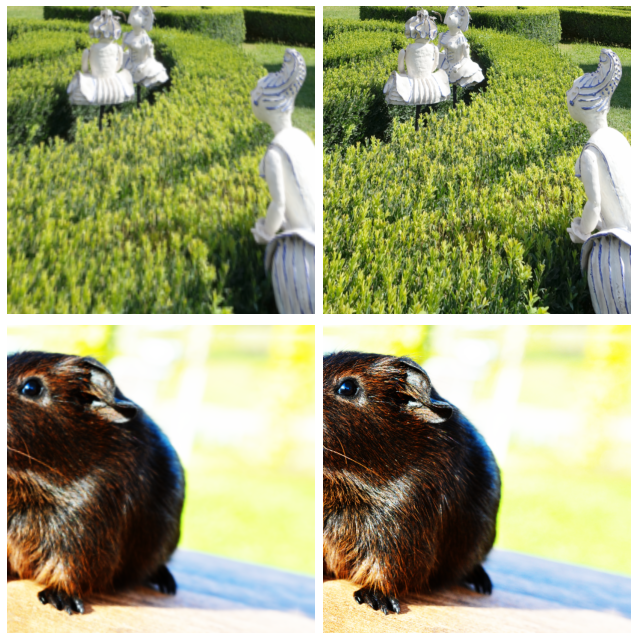

In [11]:
# example data
data = get_data(512, 8)
#data = get_dummy_data()
data.show_batch(ds_type=DatasetType.Train, rows=2, figsize=(9,9))

# Model

## Feature loss

Feature loss (also perceptual loss) using activations from a pretrained model. In this case both target and prediction is run through a VGG16 model. We're taking activations from all layers just before MaxPool2d and comparing them with L1 loss. In addition there is a standard L1 pixel level loss and and Gramm matrices of activations ($ G=A^{T}A $) compared with L1 loss.

$$ L = L_1 + L_{feat} + L_{Gramm} * 5\times10^{3}$$

Where 
$$ G_i = VGG_{16}(y)_i, \hat G_i = VGG_{16}(\hat y)_i$$

$$ L_{Gramm} = \sum_{a \in A_{y}, \hat a \in A_{\hat y}} L_1(G_i, \hat G_i)$$ 

The constant weight of Gramm matrix is taken from a fast.ai course.

In [12]:
from sisr_thesis.loss import FeatureLoss
feat_loss = FeatureLoss(layer_wgts=[5,15,2])

Let's check out which layers are we using:

In [13]:
#it is using activations from layers just before MaxPool2d
vgg_m = vgg16_bn(True).features.cuda().eval()
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True),
  ReLU(inplace=True)])

## Metrics

In addition to metrics traditionally used in image processing, PSNR and SSIM we'll used perception metrics, which are using activations from a pretrained classification AlexNet model, which is ...

### Traditional metrics
Metrics traditionally used for image restoration benchmarking are PSNR and SSIM. They not always show the similarity as perceived by human observer, but are easily measurable and suitable for comparing different algorithms on a task with no geometric deformation.

In [14]:
from fastai.metrics import psnr

"""Decorator dnormalizing image by pushing it to [0,1] range"""
def denormalize(func):
    _, denorm = normalize_funcs(*imagenet_stats)
    def _denormalized(pred, targ):
        pred = denorm(pred).clamp(min=0,max=1)
        targ = denorm(targ).clamp(min=0,max=1)
        return func(pred, targ)
    _denormalized.__name__ = func.__name__
    return _denormalized

"""Peak signal to noise ratio"""
PSNR = denormalize(psnr)


In [15]:
from ssim import ssim

SSIM = denormalize(ssim)

### LPIPS (Learned Perceptual Image Patch Similarity) metric

Paper [The Unreasonable Effectiveness of Deep Features as a Perceptual Metric](https://arxiv.org/abs/1801.03924). In principle it's similar to our Feature Loss, taking activations in this case from Alex Net and fine tuning according to a study with human participants on Amazon Mechanical Turk. There is adden another fully connected layer trying to predict the prefered image among two with different defformations. The activations from this layer are also used.

This metric was used in recent image restoration competitions such as the recent NTIRE 2020 Challenge on Real-World Image Super-Resolution.



In [16]:
_LPIPS_dist = LPIPS_models.PerceptualLoss(model='net-lin', net='alex')

@denormalize
def LPIPS(pred, targ): 
    result = _LPIPS_dist(pred, targ)
    result = torch.mean(result).squeeze()
    return result

Setting up Perceptual loss...
Loading model from: /home/luslad/thesis/PerceptualSimilarity/models/weights/v0.1/alex.pth
...[net-lin [alex]] initialized
...Done


In [17]:
metrics = [AverageMetric(PSNR), AverageMetric(SSIM), AverageMetric(LPIPS)]

## Model

In [18]:
arch = models.resnet34

In [19]:
bs,size=32,128

In [20]:
def create_generator_learner(data:ImageDataBunch, 
                            arch = models.resnet34,
                            wd = 1e-3,
                            loss_func=FeatureLoss(layer_wgts=[5,15,2]),
                            metrics=[AverageMetric(PSNR), AverageMetric(SSIM), AverageMetric(LPIPS)],
                            callback_fns=[LossMetrics]):
    learn_gen = unet_learner(data, arch, wd=wd, loss_func=feat_loss, metrics=metrics, callback_fns=[LossMetrics, ShowGraph],
                         blur=True, norm_type=NormType.Weight)
    learn_gen.path = path_dataset
    return learn_gen
    

In [21]:
wd = 1e-3
learn_gen = create_generator_learner(data)
gc.collect();

## Callbacks

### Save predicted image (same size)

Allow to compare model predictions throughout training by predicting image of the same size.

In [22]:
def get_orig(path_lr):
    return path_hr/path_lr.parent.parts[-1]/path_lr.name

def get_orig_idx(idx:int):
    return get_orig(learn_gen.data.valid_ds.x.items[idx])

def resize_keep_ar(img, max_size = 1024):
    w,h = img.shape[1], img.shape[2]
    rw = max_size / w
    rh = max_size / h
    rmin = min(rw,rh)
    w = int(round(w * rmin))
    h = int(round(h * rmin))
    return img.resize((img.shape[0], w, h)).refresh()

def image_for_prediction(idx:int):
    img = open_image(get_orig_idx(idx));
    img_lr = resize_keep_ar(img, 400) 
    img_lr = resize_keep_ar(img_lr, 800)
    return img_lr

In [23]:
class SaveTestImageCallback(LearnerCallback):
    def __init__(self, learn:Learner, path:Path, images:List[Image], save_epochs:int = 5, max_img_size=1024):
        self.learn, self.path, self.images, self.save_epochs = learn, path, images, save_epochs
        self.path.mkdir(parents=True, exist_ok=True)
        self.epoch = 0
        
        #need to set dataset
        
    def on_epoch_end(self, **kwargs):
        self.epoch += 1
        self.learn.model.eval()
        torch.cuda.empty_cache()
        with torch.no_grad():
            for i, img in enumerate(self.images):
                self.learn.data.single_ds.tfmargs['size'] = [imgs[0].shape[1],imgs[0].shape[2]]
                batch = self.learn.data.one_item(imgs[0], detach=True, denorm=False, cpu=False)
                #p,img_pred,b = self.learn.predict(img)
                res = self.pred_batch(batch=batch, with_dropout=False)
                raw_pred = grab_idx(res,0)
                raw_pred = self.data.denorm(raw_pred)
                pred = raw_pred.float().clamp(min=0,max=1)
                self._save_predicted(pred, i)
                del batch
        torch.cuda.empty_cache()
        gc.collect()
            
    def _save_predicted(self, img_pred:Tensor, img_id:int):
        x = image2np(img_pred*255).astype(np.uint8)
        filename = self.path / f"img{img_id}_e{self.epoch}.png"
        PIL.Image.fromarray(x).save(filename)

In [24]:
imgs = np.array([image_for_prediction(idx) for idx in [0,1,16]])
save_img_cb = SaveTestImageCallback(learn_gen, LOGGING_PATH/"predictions", imgs)

In [25]:
#save_img_cb.on_epoch_end()

Images to be saved:

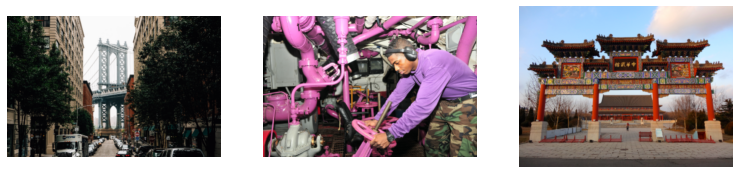

In [26]:
fig, axes = plt.subplots(1,3, figsize=(13,13))
for i, ax in enumerate(axes):
    ax.axis('off')
    ax.imshow(image2np(imgs[i].data))

### Tensorboard logger and CSV logger

In [27]:
writer = SummaryWriter(log_dir = TENSORBOARD_PATH/'GenPre')

In [28]:
tb_cb = ImageGenTensorboardWriter(learn_gen, writer, visual_iters=1)

In [29]:
class CsvLoggerEx(CSVLogger):
    def __init__(self, learn:Learner, filename: str = 'history', append: bool = False): 
        super().__init__(learn, filename, append)
        self.path = LOGGING_PATH / filename

csv_logger = CsvLoggerEx(learn_gen, 'training_history.csv', True)

# Training

## Generator Pre-Training

In [30]:
# testing metrics on dummy data
# dummy_data = get_dummy_data()
# learn_gen.data = dummy_data
# learn_gen.fit_one_cycle(2, 1e-3, pct_start=0.9, callbacks=[tb_cb])
# learn_gen.fit_one_cycle(3, 1e-3, pct_start=0.9, callbacks=[tb_cb])
# learn_gen.fit_one_cycle(5, 1e-3, pct_start=0.9, callbacks=[tb_cb])

### 32px → 64px

In [31]:
data = get_data(64,bs=44)
learn_gen.data = data

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


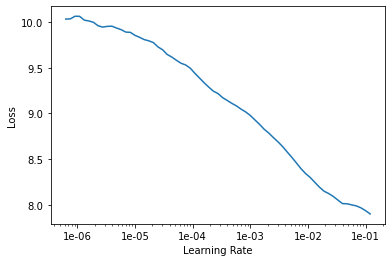

In [32]:
learn_gen.lr_find()
learn_gen.recorder.plot()

In [33]:
lr = 5e-3

In [34]:
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):                                     
    learn_gen.fit_one_cycle(10, lrs, pct_start=pct_start, callbacks=[tb_cb, csv_logger]) #, save_img_cb])
    learn_gen.save(save_name)
    learn_gen.show_results(rows=1, imgsize=5)

epoch,train_loss,valid_loss,psnr,ssim,LPIPS,pixel,feat_0,feat_1,feat_2,time
0,8.157517,7.413682,17.084969,0.477207,0.404247,0.474335,0.373806,0.558265,0.267984,00:26
1,7.396526,6.293446,19.856665,0.622180,0.277673,0.331756,0.315283,0.478325,0.236944,00:20
2,6.674322,5.448060,20.966621,0.707913,0.188099,0.278469,0.270262,0.406455,0.212084,00:20
3,6.130130,5.100739,21.169033,0.726092,0.157949,0.271042,0.251714,0.374956,0.205864,00:20
4,5.774760,4.897840,21.217398,0.732068,0.132124,0.268903,0.245657,0.363603,0.199882,00:20


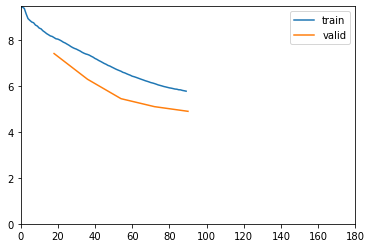

In [ ]:
do_fit('1a', slice(lr))

In [ ]:
def pretty_size(size):
	"""Pretty prints a torch.Size object"""
	assert(isinstance(size, torch.Size))
	return " × ".join(map(str, size))

def dump_tensors(gpu_only=True):
	"""Prints a list of the Tensors being tracked by the garbage collector."""
	import gc
	total_size = 0
	for obj in gc.get_objects():
		try:
			if torch.is_tensor(obj):
				if not gpu_only or obj.is_cuda:
					print("%s:%s%s %s" % (type(obj).__name__, 
										  " GPU" if obj.is_cuda else "",
										  " pinned" if obj.is_pinned else "",
										  pretty_size(obj.size())))
					total_size += obj.numel()
			elif hasattr(obj, "data") and torch.is_tensor(obj.data):
				if not gpu_only or obj.is_cuda:
					print("%s → %s:%s%s%s%s %s" % (type(obj).__name__, 
												   type(obj.data).__name__, 
												   " GPU" if obj.is_cuda else "",
												   " pinned" if obj.data.is_pinned else "",
												   " grad" if obj.requires_grad else "", 
												   " volatile" if obj.volatile else "",
												   pretty_size(obj.data.size())))
					total_size += obj.data.numel()
		except Exception as e:
			pass        
	print("Total size:", total_size)
dump_tensors()  

In [ ]:
learn_gen.unfreeze()

In [ ]:
#learn_gen.lr_find()
#learn_gen.recorder.plot()

In [ ]:
do_fit('1b', slice(1e-6,5e-4))

### 64px → 128px

In [ ]:
data = get_data(128, bs=44)

In [ ]:
learn_gen.data = data
learn_gen.freeze()
gc.collect()

In [ ]:
learn_gen.load('1b');

In [ ]:
#learn_gen.lr_find()
#learn_gen.recorder.plot()

In [ ]:
do_fit('2a', lrs=slice(lr))

In [ ]:
learn_gen.unfreeze()

In [ ]:
do_fit('2b', slice(1e-6,1e-4), pct_start=0.3)

### 128px →  256px

In [ ]:
data = get_data(256, bs=12)

In [ ]:
learn_gen.data = data
learn_gen.freeze()
gc.collect()

In [ ]:
learn_gen.load('2b');

In [ ]:
do_fit('3a')

In [ ]:
learn_gen.unfreeze()

In [ ]:
#learn_gen.lr_find()
#learn_gen.recorder.plot()

In [ ]:
do_fit('3b', slice(1e-6,1e-4), pct_start=0.3)

### 256px →  512px

In [ ]:
data = get_data(512, bs=2)

In [ ]:
learn_gen.data = data
learn_gen.freeze()
gc.collect()

In [ ]:
learn_gen.load('3b');

In [ ]:
#learn_gen.lr_find()
#learn_gen.recorder.plot()

In [ ]:
do_fit('4a')

In [ ]:
learn_gen.unfreeze()

In [ ]:
#learn_gen.lr_find(1e-10, 1e-2)
#learn_gen.recorder.plot()

In [ ]:
do_fit('4b', slice(1e-8,1e-6), pct_start=0.3)

This might not be the limit, but it will be useful tu plug this model as a generator in a GAN. We'll need to pretrain a critic for that.

## Critic Pre-Training

In [ ]:
bs=8
sz=192

In [ ]:
def save_preds(dl):
    i=0
    names = dl.dataset.items
    
    for b in dl:
        preds = learn_gen.pred_batch(batch=b, reconstruct=True)
        for o in preds:
            o.save(path_gen/names[i].name)
            i += 1
    
def save_gen_images():
    if path_gen.exists(): shutil.rmtree(path_gen)
    path_gen.mkdir(exist_ok=True)
    data_gen = get_data(bs=bs, y_size=sz, keep_pct=1.0)
    save_preds(data_gen.fix_dl)
    PIL.Image.open(path_gen.ls()[0])

In [ ]:
save_gen_images()

In [ ]:
old_checkpoint_num = 0
checkpoint_num = old_checkpoint_num + 1
gen_old_checkpoint_name = gen_name + '_' + str(old_checkpoint_num)
gen_new_checkpoint_name = gen_name + '_' + str(checkpoint_num)
crit_old_checkpoint_name = crit_name + '_' + str(old_checkpoint_num)
crit_new_checkpoint_name= crit_name + '_' + str(checkpoint_num)

In [ ]:
import pandas as pd
import numpy as np

def get_lr_hr_initial_df(size=128, scale=2):
    lr_path = generate_lr(size//scale)
    hr_path = generate_lr(size)
    return get_lr_hr_df(lr_path/"Train", hr_path/"Train")

def get_lr_hr_df(path_lr, path_hr):
    src_lr = ImageList.from_folder(path_lr)
    src_hr = ImageList.from_folder(path_hr)
    count_lr = len(src_lr)
    count_hr = len(src_hr)
    src = src_lr.add(src_hr)
    
    items = src.items
    labels = np.array(['LR']*count_lr + ['HR']*count_hr)

    num_valid = int(len(items)*0.1)
    is_valid = np.zeros(len(items), dtype=int)
    is_valid[:num_valid] = 1
    np.random.shuffle(is_valid)
    is_valid = is_valid.astype(bool)

    df = pd.DataFrame()
    df['name'] = src.items
    df['label'] = labels
    df['is_valid'] = is_valid
    return df

df = get_lr_hr_initial_df(size=128, scale=4)
df.iloc[[10,1000]]

In [ ]:
def get_crit_initial_data(bs, size, scale=2, add_transforms = True)->ImageDataBunch:
    df = get_lr_hr_initial_df(size=size, scale=scale)
    tfms = get_transforms(
                   max_zoom=1.2, max_lighting=0.5, max_warp=0.25
               ) if add_transforms else []
    data = ImageDataBunch.from_df('.', df, 
                                  bs=bs, size=size,
                                  ds_tfms = tfms,  
                                 ).normalize(imagenet_stats)
    return data

def get_crit_data(folder_gen, folder_hr, bs, size, add_transforms = True)->ImageDataBunch:
    df = get_lr_hr_df(path_lr=path_dataset/folder_gen,
                 path_hr=path_dataset/folder_hr)
    tfms = get_transforms(max_zoom=1) if add_transforms else []
    data = ImageDataBunch.from_df('.', df, 
                                  bs=bs, size=size,
                                  ds_tfms = tfms,  
                                 ).normalize(imagenet_stats)
    return data

In [ ]:
from sisr_thesis.critic import *
learn_critic = critic_learner(get_crit_data(name_gen, 'images/Train', bs=bs, size=size))

Pretraining with LR and HR pairs.

Fine tuning with generator output.

In [ ]:
# from fastai.vision.gan import *
# def critic_learner(
#     data: ImageDataBunch,
#     loss_critic=AdaptiveLoss(nn.BCEWithLogitsLoss()),
#     nf: int = 256,
# ) -> Learner:
#     return Learner(
#         data,
#         gan_critic(),
#         metrics=accuracy_thresh_expand,
#         loss_func=loss_critic,
#         callback_fns=[ShowGraph],
#         wd=1e-3,
#     )
#     learner.path = path_dataset
#     return learner

In [ ]:
writer = SummaryWriter(log_dir = TENSORBOARD_PATH/'CriticPre')

In [ ]:
if old_checkpoint_num == 0:
    bs=32
    sz=128
    learn_gen=None
    gc.collect()
    
    # initial data 
    data_crit = get_crit_initial_data(bs=bs, size=sz, scale=2)
    data_crit.show_batch(rows=2, ds_type=DatasetType.Train, imgsize=3)
    
    learn_critic = critic_learner(data=data_crit)      
    
    # callbacks
    tb_cb = LearnerTensorboardWriter(learn_critic, writer)
    csv_logger = CsvLoggerEx(learn_critic, 'critic_pretraining_history.csv', True)

    # LR vs. HR (scale 2)
    learn_critic.fit_one_cycle(10, 1e-3, callbacks=[tb_cb, csv_logger])
    
    # refinement Gen vs. HR
    data_crit = get_crit_data(name_gen, 'images/Train', bs=bs, size=size)
    data_crit.show_batch(rows=2, ds_type=DatasetType.Train, imgsize=3)
    learn_critic.data = data_crit
    learn_critic.fit_one_cycle(20, 1e-3, callbacks=[tb_cb, csv_logger])
    learn_critic.path = path_dataset
    learn_critic.save(crit_old_checkpoint_name)

In [ ]:
bs=16
size=192

In [ ]:
data_crit = get_crit_data(name_gen, 'images/Train', bs=bs, size=size)
data_crit.show_batch(rows=3, ds_type=DatasetType.Train, imgsize=3)

In [ ]:
learn_critic = critic_learner(data=data_crit)
learn_critic.path = path_dataset
learn_critic.load(crit_old_checkpoint_name, with_opt=False);

In [ ]:
learn_critic.fit_one_cycle(6, 1e-4)

In [ ]:
learn_critic.fit_one_cycle(4, 1e-4)

In [ ]:
learn_critic.save(crit_new_checkpoint_name)

## GAN training

In [ ]:
learn_crit=None
learn_gen=None
gc.collect()

In [ ]:
lr=1e-5
size=192
bs=9

In [ ]:
data_crit = get_crit_data(name_gen, 'images/Train', bs=bs, size=size)

In [ ]:
learn_critic = critic_learner(data=data_crit)
learn_critic.path = path_dataset
learn_critic.load(crit_new_checkpoint_name, with_opt=False);

In [ ]:
learn_gen = create_generator_learner(data)
learn_gen.path = path_dataset
learn_gen.load('4b', with_opt=False);

In [ ]:
def get_orig(path_lr):
    return path_hr/path_lr.parent.parts[-1]/path_lr.name

def get_orig_idx(idx:int):
    return get_orig(learn_gen.data.valid_ds.x.items[idx])

def resize_keep_ar(img, max_size = 1024):
    img = open_image(get_orig_idx(0));
    w,h = img.shape[1], img.shape[2]
    rw = max_size / w
    rh = max_size / h
    rmin = min(rw,rh)
    w = int(round(w * rmin))
    h = int(round(h * rmin))
    return img.resize((img.shape[0], w, h)).refresh()

def image_for_prediction(idx:int):
    img = open_image(get_orig_idx(idx));
    img_lr = crappify(img, 512)
    img_lr = resize_keep_ar(img_lr, 1024)
    return img_lr


In [ ]:
from fastai.basic_train import Learner, LearnerCallback
from fastai.vision.gan import GANLearner


class GANSaveCallback(LearnerCallback):
    """A `LearnerCallback` that saves history of metrics while training `learn` into CSV `filename`."""

    def __init__(
        self,
        learn: GANLearner,
        learn_gen: Learner,
        filename: str,
        save_epochs: int = 5,
    ):
        super().__init__(learn)
        self.learn_gen = learn_gen
        self.filename = filename
        self.save_epochs = save_epochs
        self.epochs = 0

    def on_epoch_end(self, iteration: int, epoch: int, **kwargs) -> None:
        self.epochs += 1
        if self.epochs % self.save_epochs == 0:
            self._save_gen_learner(epoch=epoch)

    def _save_gen_learner(self, epoch: int):
        filename = '{}_ep{}'.format(self.filename, epoch)
        self.learn_gen.save(filename)

In [ ]:
writer = SummaryWriter(log_dir = TENSORBOARD_PATH/'GanLearner')

In [ ]:
switcher = partial(AdaptiveGANSwitcher, critic_thresh=0.65)
learn = GANLearner.from_learners(learn_gen, learn_critic, weights_gen=(1.0,2.0), show_img=True, switcher=switcher,
                                 opt_func=partial(optim.Adam, betas=(0.,0.9)), wd=1e-3, metrics=metrics)
learn.callback_fns.append(partial(GANDiscriminativeLR, mult_lr=5.))
learn.callback_fns.append(partial(GANTensorboardWriter, tbwriter=writer, visual_iters=100))
learn.callback_fns.append(partial(GANSaveCallback, learn_gen=learn_gen, filename=gen_new_checkpoint_name, save_epochs=5))

In [ ]:
learn.data = get_data(y_size=size, bs=bs)
#learn_gen.freeze_to(-1)
learn.fit(100,lr, callbacks=[save_img_cb])

# Test (simple)

In [ ]:
learn_gen = None
learn_crit = None
gc.collect();

In [ ]:
torch.cuda.empty_cache()

In [ ]:
free = gpu_mem_get_free_no_cache()
# the max size of the test image depends on the available GPU RAM 
if free > 8000: size=(1280, 1600) # >  8GB RAM
else:           size=( 820, 1024) # <= 8GB RAM
print(f"using size={size}, have {free}MB of GPU RAM free")

In [ ]:
learn_gen = create_generator_learner(data)
learn_gen.path = path_dataset

In [ ]:
learn_gen.load('4b');

In [ ]:
learn_gen.load('with_GAN_0-gen_1_39_3500');

In [ ]:
learn_gen.data = get_data(1024,1)

In [ ]:
filename = learn_gen.data.valid_ds.x.items[0]; filename

In [ ]:
def get_orig(path_lr):
    return path_hr/path_lr.parent.parts[-1]/path_lr.name

def get_orig_idx(idx:int):
    return get_orig(learn_gen.data.valid_ds.x.items[idx])

open_image(get_orig_idx(0));
open_image(get_orig_idx(1));
open_image(get_orig_idx(2));


In [ ]:
def get_orig(path_lr):
    return path_hr/path_lr.parent.parts[-1]/path_lr.name
img_orig = open_image(get_orig(filename)); img_orig.shape
img_orig.resize((3, 512*2, 770*2)).refresh()
img_orig.shape

In [ ]:
img = open_image(filename); img.shape

In [ ]:
learn_gen.data.single_ds.tfmargs['size'] = [img.shape[1]*2,img.shape[2]*2]

In [ ]:
p,img_hr,b = learn_gen.predict(img)

In [ ]:
img_hr.shape

In [ ]:
show_image(img, figsize=(18,15), interpolation='nearest');

In [ ]:
show_image(img_hr.clamp(min=0,max=1), figsize=(18,15))

In [ ]:
show_image(img_orig, figsize=(18,15))